# 1. Imports

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# 2. Plot Data Utility

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    Visualises time series data

    Args:
        time (array of int) - contains the time steps
        series (array of int) - contains the measurements for each time step
        format (string) - line style when plotting the graph
        start (int) - first time step to plot
        end (int) - last time step to plot
        label (list of strings) - tag for the line
    """
    
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")

    if label:
        plt.legend(fontsize=14)
        
    plt.grid(True)

# 3. Seasonality Time Series

In [3]:
def trend(time, slope=0):
    """
    Trend describes the general tendency of the values to go up or down as time progresses. 
    Given a certain time persiod, you can if the graph is following an upward/positive, downward/negative, or flat trend.

    The slope argument will determine what the trend is.

    Args:
        time (array of int) - contains the time steps
        slope (float) - determines the direction and steepness of the line

    Returns:
        series (array of float) - measurements that follow a straight line
    """

    series = slope * time

    return series

In [27]:
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
        season_time (array of float) - contains the measurments per time step

    Returns:
        data_pattern (array of float) - contains revised measurement values according to the defined pattern
    """

    data_pattern = np.where(season_time < 0.4,
                            np.cos(season_time * 2 * np.pi),
                            1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Seasonality refers to a recurring pattern at regular time intervals.
    This function repeats the same pattern at each period

    Args:
        time (array of int) - contains the time steps
        period (int) - number of time steps before the pattern repeats
        amplitude (int) - peak measured value in a period
        phase (int) - number of time steps to shift the measured values

    Returns:
        data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


In [32]:
def noise(time, noise_level=1, seed=None):
    """
    Generates a normally distributed noisy sequel

    Args:
        time (array of int) - contains the time steps
        noise_level (float) - scaling factor for the generated signal
        seed (int) - number generator seed for repeatability

    Returns:
        noise (array of float) - the noisy signal
    """

    # Initialise the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

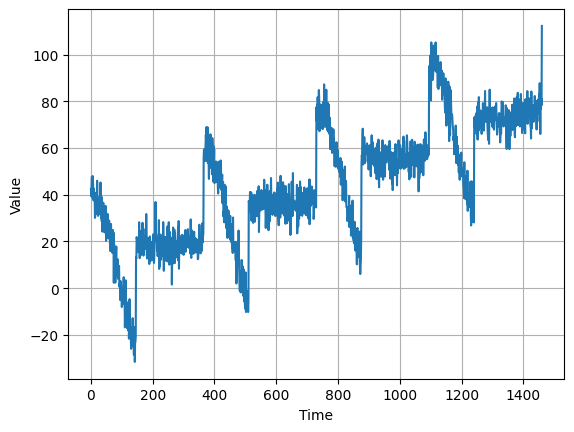

In [34]:
# A time series can contain trend AND seasonality. 
# Also, in practice, real-life data usually has some noise:

# Time series parameters
time = np.arange(4 * 365 + 1)
slope = 0.05
period = 365
amplitude = 40
noise_level = 5

# Generate the data
series = trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
noise_signal = noise(time, noise_level=noise_level, seed=42)

series += noise_signal

plot_series(time, series)

# 4. Autocorrelation Time Series

Time series can also be autocorrelated.

This means that measurements at a given time step is a function of previous time steps.

In [35]:
def autocorrelation(time, amplitude, seed=None):
    # amplitude: scaling factor

    rnd = np.random.RandomState(seed)

    # Initalise array of random numbers equal to the length of the given time steps, plus 50
    # Using random data to be more realistic
    ar = rnd.randn(len(time) + 50)

    # set first 50 elemnts to a constant ( we will get rid of these as, below, you cannot get t-50 for t<50)
    ar[:50] = 100

    # define the scaling factors
    phi1 = 0.5
    phi2 = -0.1

    # Autocorrelate element 51 onwards with the measurement at (t-50 and (t-30), where to is the current time step
    for step in range(50, len(time) + 50):
        ar[step] += phi1 * ar[step - 50]
        ar[step] += phi2 * ar[step - 30]

    # Get the autocorrelated data and scale with the given amplitude
    # The first 50 elements of the original array is truncated because
    # those are just constant and not autocorrelated
    ar = ar[50:] * amplitude

    return ar


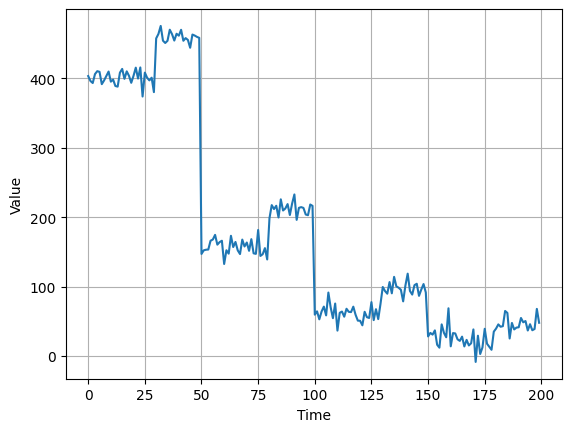

In [36]:
series = autocorrelation(time, amplitude=10, seed=42)

plot_series(time[:200], series[:200])

In [37]:
# Another type of (more straight forward) autocorrelation that just computes a value from the previous time step

def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)

    phi = 0.8
    ar = rnd.randn(len(time) + 1)

    for step in range(1, len(time) + 1):
        ar[step] += phi * ar[step - 1]

    return ar[1:] * amplitude

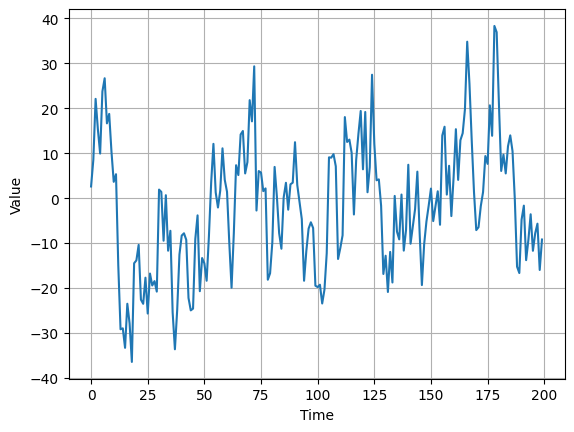

In [38]:
series = autocorrelation(time, 10, seed=42)

plot_series(time[:200], series[:200])

In [41]:
# Another type of autocorrelated time series is one where it decays predictable after random spikes:

def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)

    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))

    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
        
    return series  

In [46]:
# Now lets see the function that will cause the impulse series to decay after it spikes

# phis is a dict containing the lag time and decay rates
def autocorrelation_impulses(source, phis):
    ar = source.copy()
    max_lag = len(phis)

    for step, value in enumerate(source):
        for lag, phi in phis.items():
            if step - lag > 0:
              ar[step] += phi * ar[step - lag]

    return ar

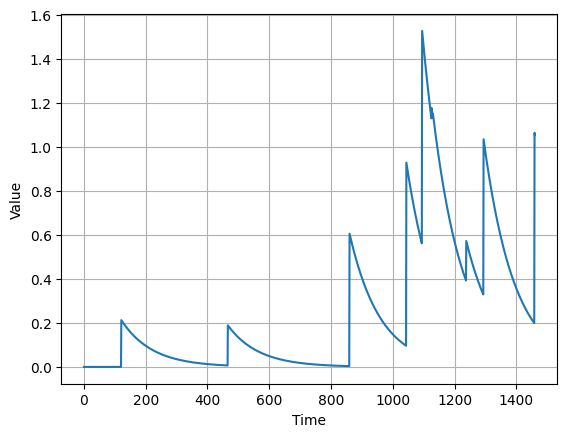

In [69]:
signal = impulses(time, 10, seed=42)
series = autocorrelation_impulses(signal, {1: 0.99})

plot_series(time, series)

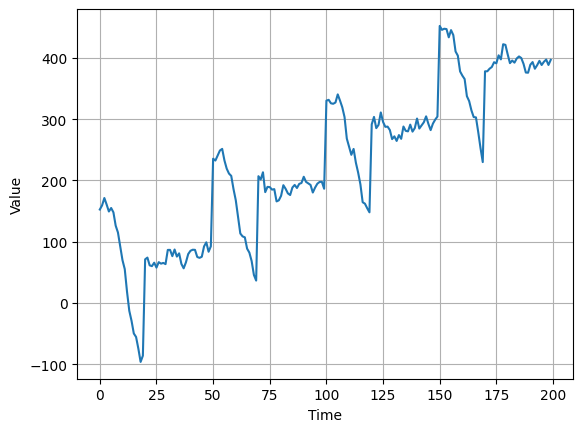

In [71]:
# Seasonality, trend, and autocorrelation can also be combined:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)

plot_series(time[:200], series[:200])

# 5. Non-stationary Time Series

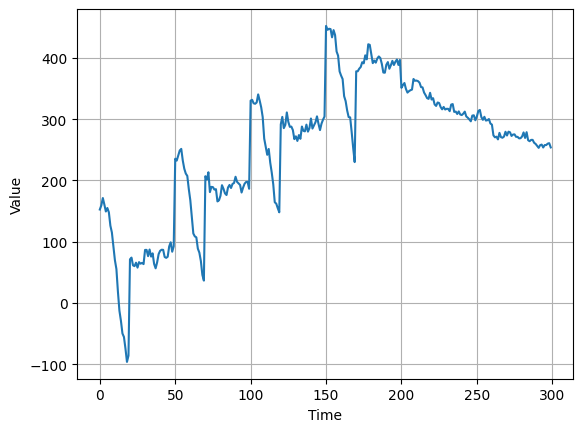

In [72]:
# It is also possible for tie series to break an unexpected pattern. 
# Big events can alter the trend or seasonal behaviour of the data.

# Generating data with positive trend
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)

# Generate data with negative trend
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550

series[200:] = series2[200:]

# In this case, you may want to train your model on the later teps (i.e. starting at t=200) 
# Since these present a stronger predictive signal to future time steps
plot_series(time[:300], series[:300])

# 6. Generating Data to train and predict with

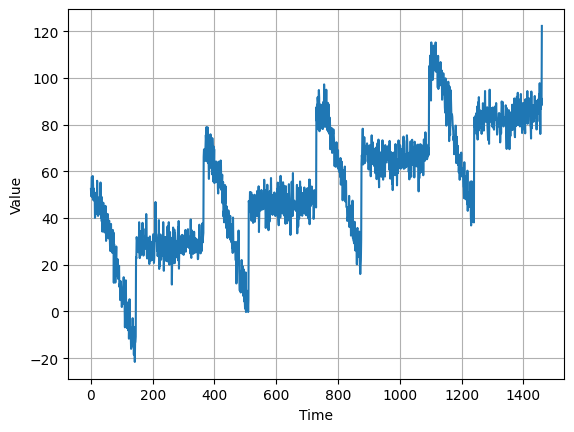

In [73]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

plot_series(time, series)

# 7. Split the Dataset

In [74]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# 8. Naive Forecast (baseline)

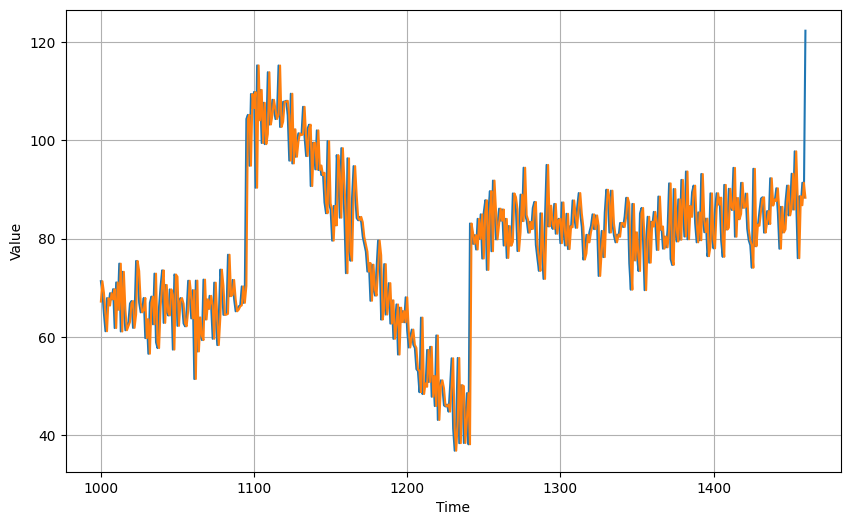

In [76]:
# Where you assume that the next value will be the same as the previous (actual) time step.
# The next time step value should be identical to the ground truth at the previous time step.

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

In [79]:
# Computing metrics:

print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.9379086


# 9. Moving Average Forecast

In [80]:
# Another technique is to use the moving average.
# This sums up a series of time steps and the average will be the prediction for the next step
# For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11

# The function below does the moving average for the entire series.
# It takes a window_size to indicate the number of time steps to consider when computing the mean

def moving_average_forecast(series, window_size):
  """
  Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
  """

  forecast = []

  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
    
  return np.array(forecast)

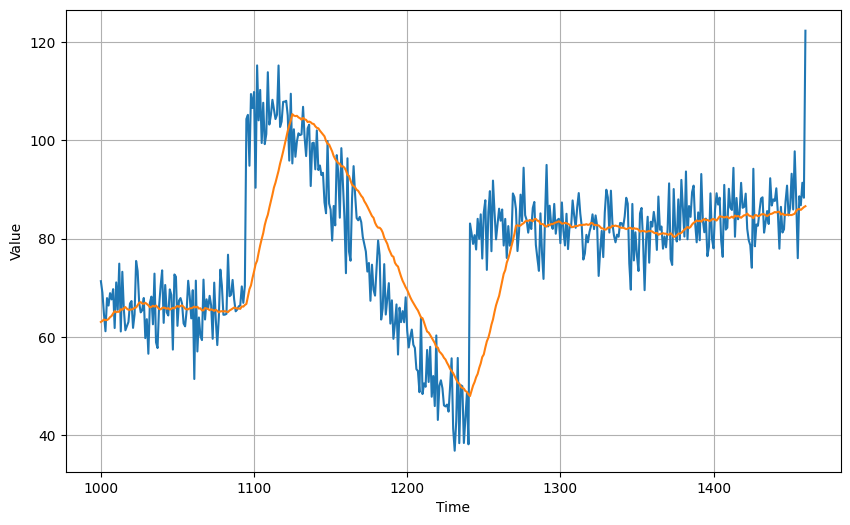

In [84]:
# We have to do `split_time - 30` because window_size = 30. 
# We need to use the last 30 values of the training data to create the first prediction in the validation dataset
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [86]:
# Computing metrics:

# This looks worse than the Naive forecast.
# The moving average does not anticipate trend or seasonality. In particular, those huge spikes cause big deviations in the plot above.
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.1424184


# 10. Differencing Forecast

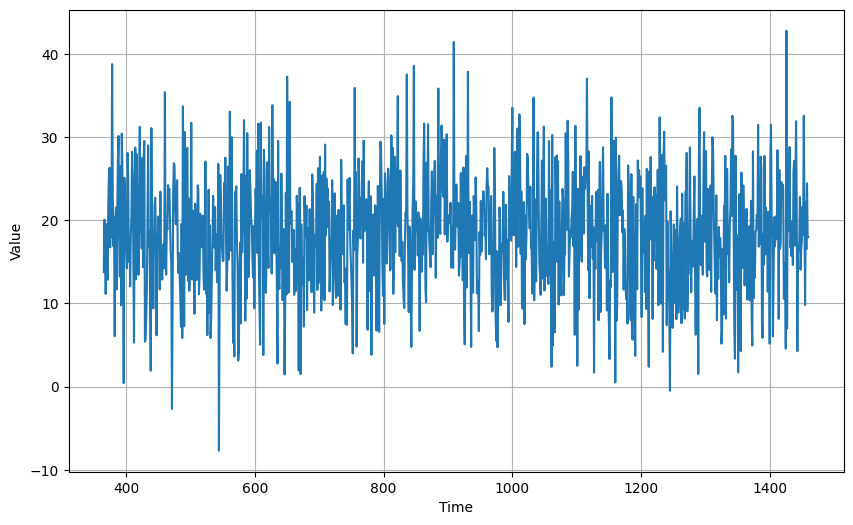

In [100]:
# Since the seasonality period is 365 days, we will subtract the value at t-365 from the value at time t
# In addition, we will need to align the result with the time array. Since you cannot do time differencing for t < 365, 
# we will need to truncate the first 365 time teps of the time array

# subtract the values at t-365 from original series
diff_series = (series[365:] - series[:-365])

# truncate the first 365 time steps
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)

In [101]:
# Great, the trend and seasonality appears to be gone, lets try using the moving average again.

# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 50)

# slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 50:]

# slice the ground truth points that corresponds tot he validation set time steps
diff_series = diff_series[split_time - 365:]

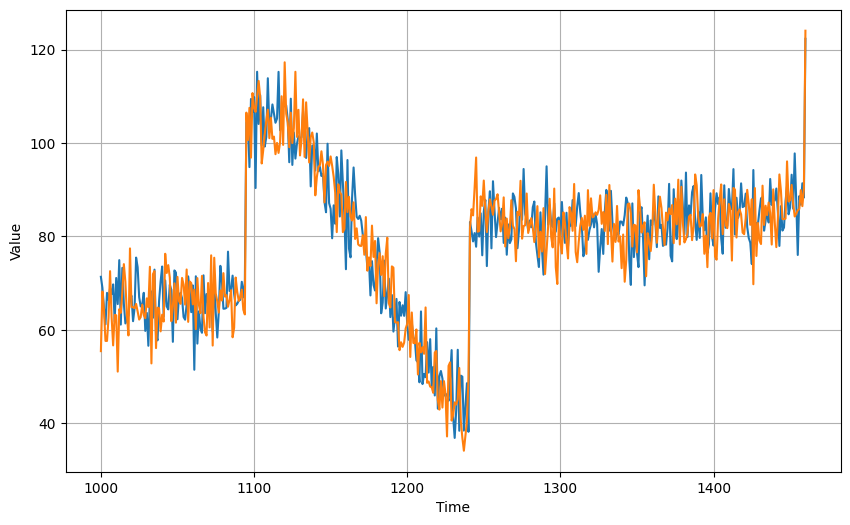

In [102]:
# Now we MUST bring back the trend and seasonality by adding the past values from t-365

# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)

plt.show()

In [104]:
# Computing metrics:

# This looks a bit better
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97366
5.8393106


# 11. Smoothing your Forecast

You can use the same moving_average_forecast() function to SMOOTH out past values before adding them back to the time difference moving average. There are two ways to do this:
- Trailing windows - getting the mean of past values to smooth out the value at the current time step
- Centered windows - getting the mean of past and future values to smooth out the value at the current time step

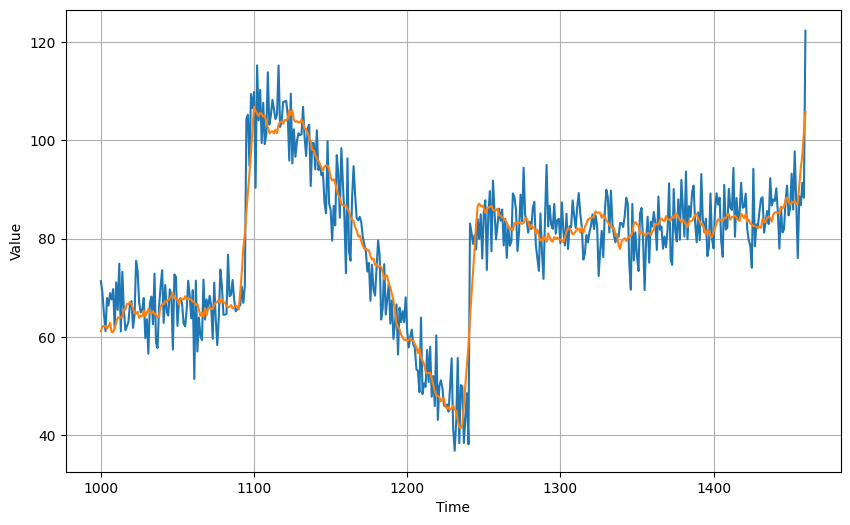

In [105]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [106]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.452263
4.569442
